# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import warnings
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
%matplotlib inline
plt.style.use("seaborn-white")

In [2]:
df = pd.read_csv("crime_reports.csv")

In [3]:
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287238 entries, 0 to 2287237
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20873
Address                             12
Zip Code                         14017
Council District                 47056
APD Sector                        8898
APD District                      9372
PRA                              10623
Census Tract                   1512068
Clearance Status                604722
Clearance Date                  335516
UCR Category                   1508290
Category Description           1508290
X-coordinate                     10049
Y-coordinate                     10049
Latitude                         38612
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20125003262,PROTECTIVE ORDER,3829,N,01/23/2012 05:17:00 AM,01/23/2012,517.0,01/23/2012 05:17:00 AM,01/23/2012,517.0,RESIDENCE / HOME,UNKNOWN,NaN,NaN,DA,1,491,NaN,N,01/23/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20072832112,ASSAULT WITH INJURY,900,N,10/10/2007 09:00:00 PM,10/10/2007,2100.0,10/10/2007 10:00:00 PM,10/10/2007,2200.0,BAR / NIGHT CLUB,HOT BODIES CLUB HWY 71 & BURLESON RD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20081232700,FAMILY DISTURBANCE,3400,N,05/02/2008 11:11:00 PM,05/02/2008,2311.0,05/02/2008 11:11:00 PM,05/02/2008,2311.0,RESIDENCE / HOME,9702 CHILSOM TRAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006900236,ASSAULT WITH INJURY,900,N,03/31/2006 02:50:00 AM,03/31/2006,250.0,03/31/2006 02:50:00 AM,03/31/2006,250.0,RESIDENCE / HOME,721 LAMAR PLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20081002040,CRASH/FAIL STOP AND RENDER AID,3604,N,04/09/2008 07:04:00 PM,04/09/2008,1904.0,04/09/2008 09:08:00 PM,04/09/2008,2108.0,STREETS / HWY / ROAD / ALLEY,2500 BLOCK OF GUADALUPE,NaN,NaN,NaN,NaN,NaN,NaN,N,12/16/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2287233,2020951013,THEFT BY SHOPLIFTING,607,N,04/04/2020 08:01:00 PM,04/04/2020,2001.0,04/04/2020 08:01:00 PM,04/04/2020,2001.0,DEPARTMENT / DISCOUNT STORE,710 E BEN WHITE BLVD SVRD WB,NaN,NaN,DA,2,480,NaN,C,04/04/2020,23C,Theft,3111086.0,3111086.0,30.218415,-97.754358,"(30.21841503, -97.75435779)"
2287234,20132071704,VIOL CITY ORDINANCE - OTHER,3299,N,07/26/2013 07:54:00 PM,07/26/2013,1954.0,07/26/2013 07:54:00 PM,07/26/2013,1954.0,STREETS / HWY / ROAD / ALLEY,400 BLOCK NECHES ST,78701.0,9.0,GE,2,382,NaN,C,08/13/2013,NaN,NaN,3115585.0,3115585.0,30.265413,-97.738848,"(30.26541298, -97.73884756)"
2287235,2003924076801,BURGLARY OF RESIDENCE,500,N,01/04/2003 06:30:00 PM,01/04/2003,1830.0,01/05/2003 10:31:00 AM,01/05/2003,1031.0,RESIDENCE / HOME,1809 SANCHEZ ST,78702.0,1.0,CH,3,394,8.0,N,NaN,220,Burglary,3125587.0,3125587.0,30.281489,-97.706719,"(30.28148881, -97.70671938)"
2287236,2006902409,BURGLARY NON RESIDENCE,502,N,03/31/2006 10:46:00 PM,03/31/2006,2246.0,03/31/2006 10:46:00 PM,03/31/2006,2246.0,COMMERCIAL / OFFICE BUILDING,6016 OLD FREDERICKSBURG RD,78749.0,8.0,DA,6,78,NaN,NaN,05/10/2006,220,Burglary,3081299.0,3081299.0,30.234197,-97.848283,"(30.2341966, -97.8482829)"
2287237,2010232299,FAMILY DISTURBANCE,3400,N,01/23/2010 10:44:00 PM,01/23/2010,2244.0,01/24/2010 12:14:00 AM,01/24/2010,14.0,RESIDENCE / HOME,9307 GEORGIAN DR,78753.0,4.0,ED,1,250,18.0,N,02/06/2010,NaN,NaN,3129098.0,3129098.0,30.360317,-97.693437,"(30.36031662, -97.69343723)"


## II. Data Scrubbing

There are several columns of data we don't need. We'll drop those and also scrub the Columns were keeping for analysis. Mainly, we want the zip code and address columns to be free of nulls and duplicates. We'll also create new columns for time series analysis. 

In [4]:
def clean_data(df):
    drop_col = [
        "Occurred Time",
        "Occurred Date",
        "Highest Offense Code",
        "Census Tract",
        "Family Violence",
        "Clearance Status",
        "PRA",
        "Report Date",
        "Report Time",
        "Clearance Date",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]

    clean_col = ["Occurred Date Time", "Report Date Time"]

    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

    date_col = ["occurred_date_time", "report_date_time"]

    cat_col = ["highest_offense_description", "location_type", "apd_sector"]

    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")

    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour

    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)

    return df


df = clean_data(df)

In [5]:
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2287073 entries, 2003-01-01 00:00:00 to 2020-11-21 21:13:00
Data columns (total 16 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   incident_number              int64         
 1   highest_offense_description  category      
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     float64       
 6   council_district             float64       
 7   apd_sector                   category      
 8   apd_district                 object        
 9   latitude                     float64       
 10  longitude                    float64       
 11  year                         int64         
 12  month                        int64         
 13  week                         int64         
 14  day                          int64         
 15  hour            

None

incident_number                    0
highest_offense_description        0
report_date_time                   0
location_type                  20789
address                           12
zip_code                       14004
council_district               47043
apd_sector                      8896
apd_district                    9370
latitude                       38606
longitude                      38606
year                               0
month                              0
week                               0
day                                0
hour                               0
dtype: int64

,incident_number,highest_offense_description,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,
2003-01-01,20125023519,IDENTITY THEFT,2012-05-25 11:04:00,RESIDENCE / HOME,1105 LILY TER,78741.0,3.0,HE,3,30.234098,-97.701901,2003,1,1,1,0
2003-01-01,20125033273,AGG SEXUAL ASSAULT CHILD/OBJEC,2012-07-18 12:00:00,RESIDENCE / HOME,1100 BLOCK HARVEY ST,78702.0,1.0,CH,2,NaN,NaN,2003,1,1,1,0
2003-01-01,20172751388,INDECENCY WITH A CHILD/CONTACT,2017-10-02 21:14:00,RESIDENCE / HOME,1200 BLOCK AUSTIN HIGHLANDS BLVD,78745.0,2.0,FR,4,NaN,NaN,2003,1,1,1,0
2003-01-01,20085024074,IDENTITY THEFT,2008-05-10 18:36:00,RESIDENCE / HOME,7312 WHISPERING OAKS DR,78745.0,5.0,FR,1,30.202175,-97.817542,2003,1,1,1,0
2003-01-01,20071300652,INDECENCY WITH A CHILD/CONTACT,2007-05-10 09:52:00,RESIDENCE / HOME,9400 BLOCK GROUSE MEADOW LN,78758.0,4.0,ED,1,NaN,NaN,2003,1,1,1,0


,incident_number,highest_offense_description,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,
2020-11-21 17:50:00,20205047581,TERRORISTIC THREAT,2020-11-21 19:03:00,RESIDENCE / HOME,10801 S IH 35 SVRD NB,78747.0,5.0,FR,7,30.144638,-97.793008,2020,11,47,21,17
2020-11-21 18:39:00,20203261239,UNLAWFUL CARRYING WEAPON,2020-11-21 23:05:00,STREETS / HWY / ROAD / ALLEY,3600 S IH 35 SB,78704.0,3.0,DA,2,30.218405,-97.750469,2020,11,47,21,18
2020-11-21 19:05:00,20205047582,DEBIT CARD ABUSE,2020-11-21 19:05:00,OTHER / UNKNOWN,3300 MANOR RD,78723.0,1.0,BA,4,30.287236,-97.702506,2020,11,47,21,19
2020-11-21 19:58:00,20205047586,THEFT,2020-11-21 20:15:00,SPECIALTY STORE (TV FUR ETC.),1200 BARBARA JORDAN BLVD,78723.0,9.0,BA,4,30.307383,-97.709238,2020,11,47,21,19
2020-11-21 21:13:00,20205047590,BURGLARY NON RESIDENCE,2020-11-21 21:13:00,OTHER / UNKNOWN,2525 S IH 35 SVRD NB,78741.0,3.0,HE,2,30.230486,-97.742073,2020,11,47,21,21


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

#### Overall crime rates over time 

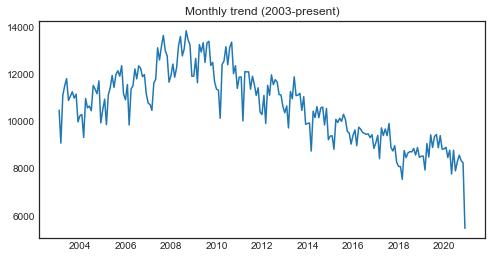

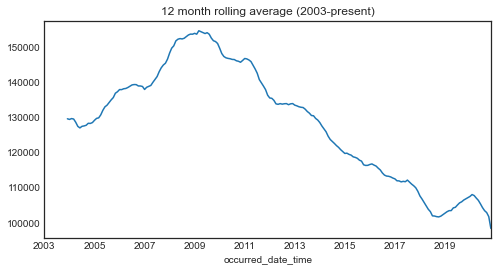

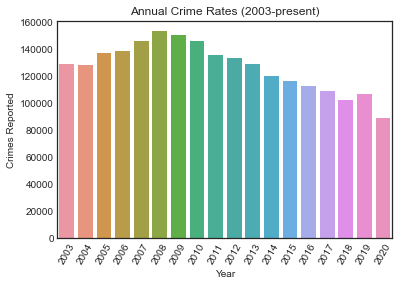

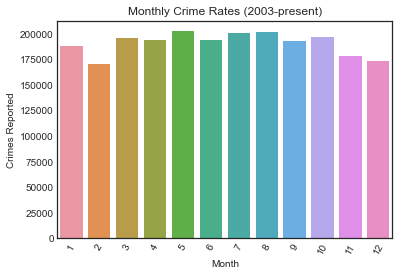

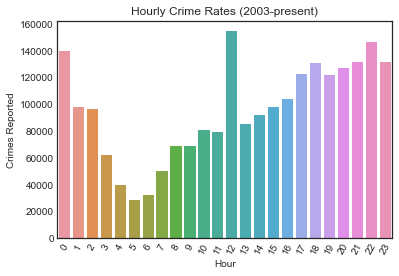

In [6]:
# Plotting overall trend on a monthly basis
plt.figure(figsize=(8, 4))
plt.plot(df.resample("M").size())
plt.title("Monthly trend (2003-present)")
plt.show()

# Above plot re-shown with a rolling average
plt.figure(figsize=(8, 4))
df.resample("M").size().rolling(12).sum().plot()
plt.title("12 month rolling average (2003-present)")
plt.show()

print("===============================================================================")
print("===============================================================================")

# Visualizing overall yearly crime rate since 2003
crimes_per_year = df["year"].value_counts().sort_index()
g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(
    xlabel="Year", ylabel="Crimes Reported", title="Annual Crime Rates (2003-present)"
)
plt.show()

# Overall monthly crime rate
crimes_per_month = df["month"].value_counts().sort_index()
d = sns.barplot(x=crimes_per_month.index, y=crimes_per_month.values)
d.set_xticklabels(d.get_xticklabels(), rotation=60)
d.set(
    xlabel="Month", ylabel="Crimes Reported", title="Monthly Crime Rates (2003-present)"
)
plt.show()

# Overall hourly crime rates as well
crimes_per_hour = df["hour"].value_counts().sort_index()
e = sns.barplot(x=crimes_per_hour.index, y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), rotation=60)
e.set(
    xlabel="Hour", ylabel="Crimes Reported", title="Hourly Crime Rates (2003-present)"
)
plt.show()

#### Top 25 crime types 

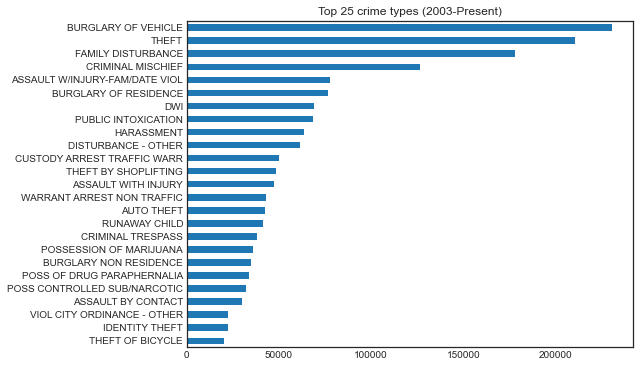

In [26]:
df.highest_offense_description.value_counts().head(25).sort_values().plot.barh(
    figsize=(8, 6), title="Top 25 crime types (2003-Present)"
)

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    205628
78753.0    177675
78701.0    167724
78758.0    158069
78704.0    153726
78745.0    149892
78702.0    136200
78744.0    125531
78723.0    117633
78752.0     83981
78748.0     67601
78759.0     65837
78751.0     63746
78757.0     57466
78705.0     56742
78721.0     47453
78749.0     40193
78724.0     37447
78727.0     35623
78703.0     35013
78731.0     28454
78746.0     27983
78729.0     25314
78750.0     23509
78754.0     22596
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090463
78753.0    0.078165
78701.0    0.073787
78758.0    0.069540
78704.0    0.067629
78745.0    0.065943
78702.0    0.059919
78744.0    0.055225
78723.0    0.051751
78752.0    0.036946
78748.0    0.029740
78759.0    0.028964
78751.0    0.028044
78757.0    0.025281
78705.0    0.024963
78721.0    0.020876
78749.0    0.017682
78724.0    0.016474
78727.0    0.015672
78703.0    0.015403
78731.0    0.012518
78746.0    0.012311
78729.0    0.011136
78750.0    0.010342
78754.0    0.009941
Name: zip_code, dtype: float64

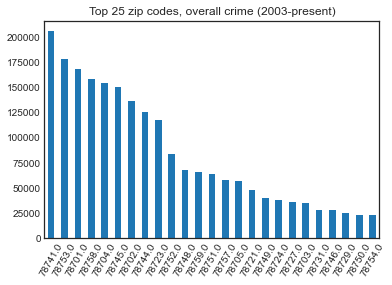

In [8]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))


# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime (2003-present)"
)
plt.show()

#### Taking a closer look at particular areas... 

The next section will examine the zip codes 78701 (downtown), 78753, 78741, and 78745.

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701? 

PUBLIC INTOXICATION               17136
THEFT                             15688
BURGLARY OF VEHICLE                9229
WARRANT ARREST NON TRAFFIC         8968
DWI                                8287
ASSAULT WITH INJURY                7470
VIOL CITY ORDINANCE - OTHER        6187
POSS OF DRUG PARAPHERNALIA         6015
CRIMINAL MISCHIEF                  5770
CRIMINAL TRESPASS                  3891
POSSESSION OF MARIJUANA            3373
DISTURBANCE - OTHER                3324
CUSTODY ARREST TRAFFIC WARR        3001
POSS CONTROLLED SUB/NARCOTIC       2883
CAMPING IN PARK                    2791
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2573
ASSAULT BY CONTACT                 2560
THEFT OF BICYCLE                   2495
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2128
PROTECTIVE ORDER                   2101
DOC FIGHTING                       2101
ASSAULT W/INJURY-FAM/DATE VIOL     1719
Name: highest_offense_description, dtype

----------------------------------


PUBLIC INTOXICATION               0.102168
THEFT                             0.093535
BURGLARY OF VEHICLE               0.055025
WARRANT ARREST NON TRAFFIC        0.053469
DWI                               0.049409
ASSAULT WITH INJURY               0.044537
VIOL CITY ORDINANCE - OTHER       0.036888
POSS OF DRUG PARAPHERNALIA        0.035862
CRIMINAL MISCHIEF                 0.034402
CRIMINAL TRESPASS                 0.023199
POSSESSION OF MARIJUANA           0.020110
DISTURBANCE - OTHER               0.019818
CUSTODY ARREST TRAFFIC WARR       0.017892
POSS CONTROLLED SUB/NARCOTIC      0.017189
CAMPING IN PARK                   0.016640
VOCO - ALCOHOL  CONSUMPTION       0.016038
CRIMINAL TRESPASS/TRANSIENT       0.015341
ASSAULT BY CONTACT                0.015263
THEFT OF BICYCLE                  0.014876
URINATING IN PUBLIC PLACE         0.013928
FAMILY DISTURBANCE                0.012688
PROTECTIVE ORDER                  0.012527
DOC FIGHTING                      0.012527
ASSAULT W/I

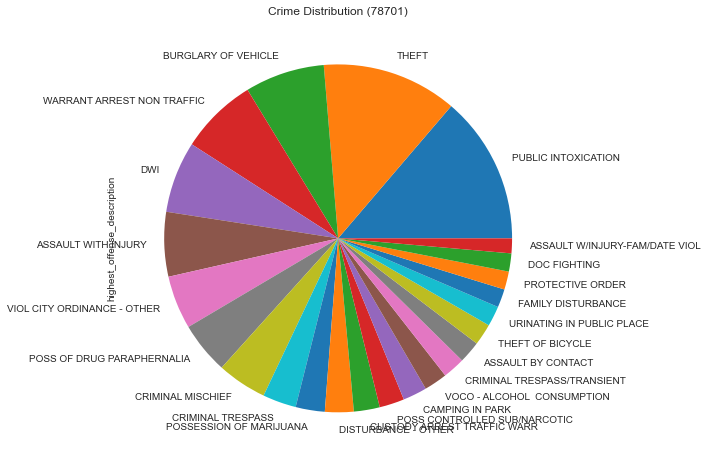

In [9]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
print("----------------------------------")
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17047
BURGLARY OF VEHICLE               15890
FAMILY DISTURBANCE                14515
CRIMINAL MISCHIEF                  9371
THEFT BY SHOPLIFTING               7589
ASSAULT W/INJURY-FAM/DATE VIOL     7091
BURGLARY OF RESIDENCE              6034
DWI                                4937
DISTURBANCE - OTHER                4728
CUSTODY ARREST TRAFFIC WARR        4335
HARASSMENT                         4208
AUTO THEFT                         4150
POSS OF DRUG PARAPHERNALIA         3719
PUBLIC INTOXICATION                3361
ASSAULT WITH INJURY                3276
CRIMINAL TRESPASS                  3123
POSS CONTROLLED SUB/NARCOTIC       2958
RUNAWAY CHILD                      2915
WARRANT ARREST NON TRAFFIC         2789
POSSESSION OF MARIJUANA            2692
BURGLARY NON RESIDENCE             2473
VIOL CITY ORDINANCE - OTHER        1865
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.095945
BURGLARY OF VEHICLE               0.089433
FAMILY DISTURBANCE                0.081694
CRIMINAL MISCHIEF                 0.052742
THEFT BY SHOPLIFTING              0.042713
ASSAULT W/INJURY-FAM/DATE VIOL    0.039910
BURGLARY OF RESIDENCE             0.033961
DWI                               0.027787
DISTURBANCE - OTHER               0.026610
CUSTODY ARREST TRAFFIC WARR       0.024398
HARASSMENT                        0.023684
AUTO THEFT                        0.023357
POSS OF DRUG PARAPHERNALIA        0.020931
PUBLIC INTOXICATION               0.018917
ASSAULT WITH INJURY               0.018438
CRIMINAL TRESPASS                 0.017577
POSS CONTROLLED SUB/NARCOTIC      0.016648
RUNAWAY CHILD                     0.016406
WARRANT ARREST NON TRAFFIC        0.015697
POSSESSION OF MARIJUANA           0.015151
BURGLARY NON RESIDENCE            0.013919
VIOL CITY ORDINANCE - OTHER       0.010497
Name: highest_offense_description, dtype: float64

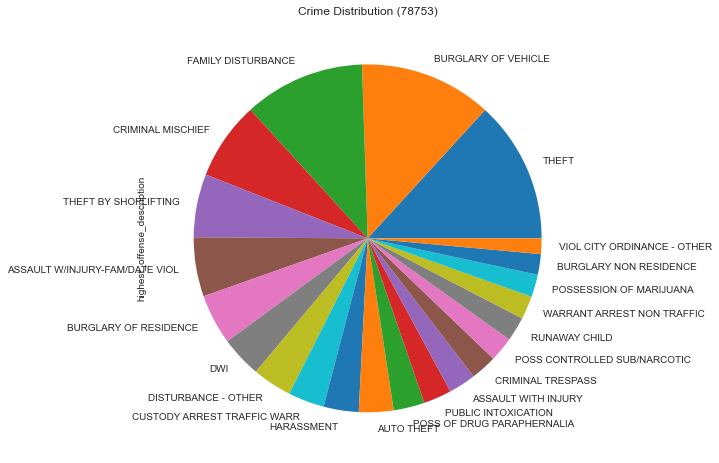

In [10]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]


# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)


# Display the different crime values & then as percentages
display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20200
BURGLARY OF VEHICLE               19739
THEFT                             15516
CRIMINAL MISCHIEF                 10980
ASSAULT W/INJURY-FAM/DATE VIOL     9590
BURGLARY OF RESIDENCE              8849
PUBLIC INTOXICATION                6370
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5627
HARASSMENT                         5461
DISTURBANCE - OTHER                5134
AUTO THEFT                         4570
ASSAULT WITH INJURY                4516
CRIMINAL TRESPASS                  3887
POSS CONTROLLED SUB/NARCOTIC       3841
POSSESSION OF MARIJUANA            3791
THEFT BY SHOPLIFTING               3566
POSS OF DRUG PARAPHERNALIA         3527
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2780
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098236
BURGLARY OF VEHICLE               0.095994
THEFT                             0.075457
CRIMINAL MISCHIEF                 0.053397
ASSAULT W/INJURY-FAM/DATE VIOL    0.046638
BURGLARY OF RESIDENCE             0.043034
PUBLIC INTOXICATION               0.030978
CUSTODY ARREST TRAFFIC WARR       0.029232
DWI                               0.027365
HARASSMENT                        0.026558
DISTURBANCE - OTHER               0.024967
AUTO THEFT                        0.022225
ASSAULT WITH INJURY               0.021962
CRIMINAL TRESPASS                 0.018903
POSS CONTROLLED SUB/NARCOTIC      0.018679
POSSESSION OF MARIJUANA           0.018436
THEFT BY SHOPLIFTING              0.017342
POSS OF DRUG PARAPHERNALIA        0.017152
WARRANT ARREST NON TRAFFIC        0.016768
RUNAWAY CHILD                     0.013520
VIOL CITY ORDINANCE - OTHER       0.010679
Name: highest_offense_description, dtype: float64

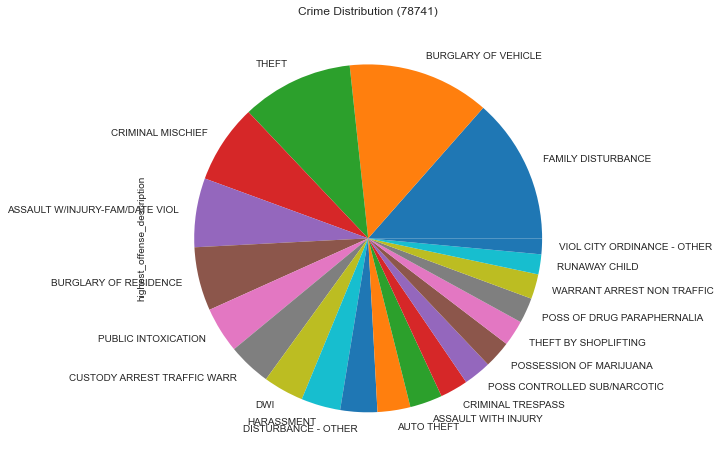

In [11]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]


# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)


# Display the different crime values & then as percentages
display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745?

FAMILY DISTURBANCE                14806
BURGLARY OF VEHICLE               14719
THEFT                             13483
CRIMINAL MISCHIEF                  8453
BURGLARY OF RESIDENCE              5853
ASSAULT W/INJURY-FAM/DATE VIOL     5723
HARASSMENT                         5103
DISTURBANCE - OTHER                4486
DWI                                4393
PUBLIC INTOXICATION                3990
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2912
AUTO THEFT                         2815
ASSAULT WITH INJURY                2643
RUNAWAY CHILD                      2589
POSSESSION OF MARIJUANA            2584
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2010
THEFT BY SHOPLIFTING               1961
CRIMINAL TRESPASS                  1938
IDENTITY THEFT                     1555
POSS OF DRUG PARAPHERNALIA         1514
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098778
BURGLARY OF VEHICLE               0.098197
THEFT                             0.089951
CRIMINAL MISCHIEF                 0.056394
BURGLARY OF RESIDENCE             0.039048
ASSAULT W/INJURY-FAM/DATE VIOL    0.038181
HARASSMENT                        0.034045
DISTURBANCE - OTHER               0.029928
DWI                               0.029308
PUBLIC INTOXICATION               0.026619
CUSTODY ARREST TRAFFIC WARR       0.021642
BURGLARY NON RESIDENCE            0.019427
AUTO THEFT                        0.018780
ASSAULT WITH INJURY               0.017633
RUNAWAY CHILD                     0.017272
POSSESSION OF MARIJUANA           0.017239
WARRANT ARREST NON TRAFFIC        0.014063
POSS CONTROLLED SUB/NARCOTIC      0.013410
THEFT BY SHOPLIFTING              0.013083
CRIMINAL TRESPASS                 0.012929
IDENTITY THEFT                    0.010374
POSS OF DRUG PARAPHERNALIA        0.010101
Name: highest_offense_description, dtype: float64

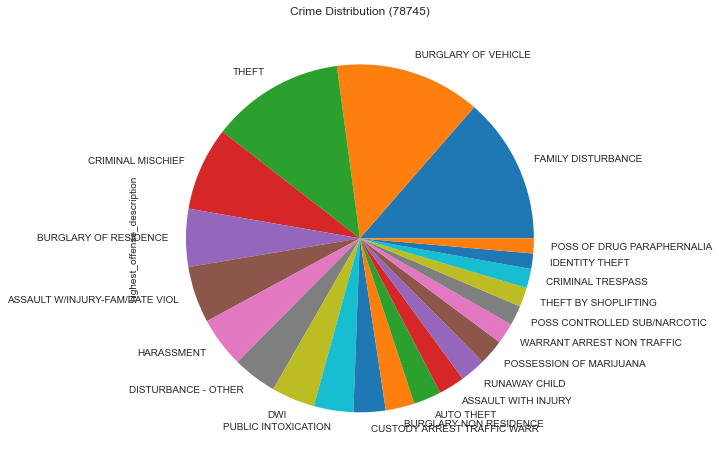

In [12]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]


# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)


# Display the different crime values & then as percentages
display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705?

BURGLARY OF VEHICLE               8587
THEFT                             5578
CRIMINAL MISCHIEF                 4940
THEFT OF BICYCLE                  3443
PUBLIC INTOXICATION               2625
BURGLARY OF RESIDENCE             2114
WARRANT ARREST NON TRAFFIC        1547
CRIMINAL TRESPASS                 1335
AUTO THEFT                        1289
ASSAULT WITH INJURY               1239
DWI                               1223
HARASSMENT                        1201
FAMILY DISTURBANCE                1172
DISTURBANCE - OTHER               1108
BURGLARY NON RESIDENCE             869
CRIMINAL TRESPASS/TRANSIENT        867
VIOL CITY ORDINANCE - OTHER        790
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           774
ASSAULT W/INJURY-FAM/DATE VIOL     681
POSSESSION OF MARIJUANA            656
ASSAULT BY CONTACT                 612
Name: highest_offense_description, dtype: int64

----------------------------------


BURGLARY OF VEHICLE               0.151334
THEFT                             0.098305
CRIMINAL MISCHIEF                 0.087061
THEFT OF BICYCLE                  0.060678
PUBLIC INTOXICATION               0.046262
BURGLARY OF RESIDENCE             0.037256
WARRANT ARREST NON TRAFFIC        0.027264
CRIMINAL TRESPASS                 0.023528
AUTO THEFT                        0.022717
ASSAULT WITH INJURY               0.021836
DWI                               0.021554
HARASSMENT                        0.021166
FAMILY DISTURBANCE                0.020655
DISTURBANCE - OTHER               0.019527
BURGLARY NON RESIDENCE            0.015315
CRIMINAL TRESPASS/TRANSIENT       0.015280
VIOL CITY ORDINANCE - OTHER       0.013923
CUSTODY ARREST TRAFFIC WARR       0.013799
GRAFFITI                          0.013641
ASSAULT W/INJURY-FAM/DATE VIOL    0.012002
POSSESSION OF MARIJUANA           0.011561
ASSAULT BY CONTACT                0.010786
Name: highest_offense_description, dtype: float64

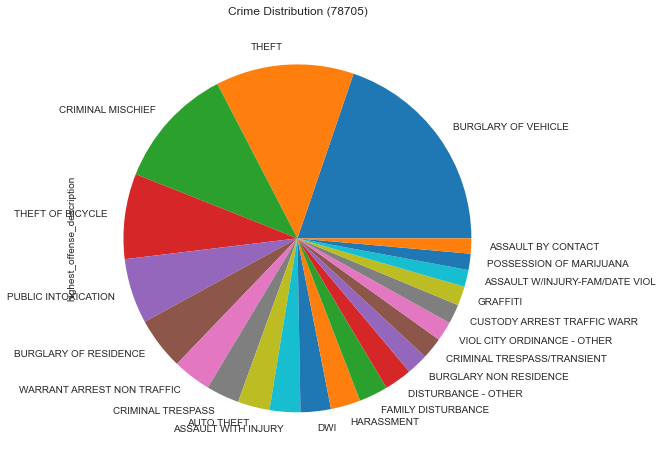

In [24]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]


# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)


# Display the different crime values & then as percentages
display(df_05_off)
print("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

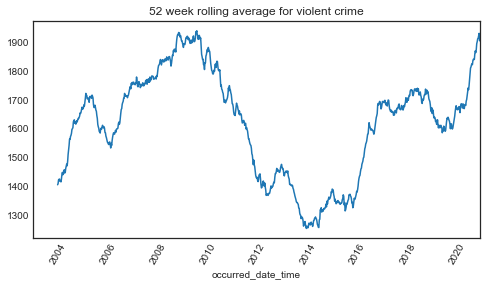

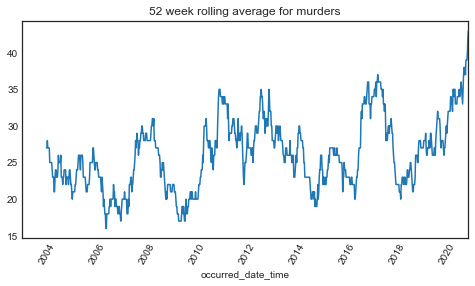

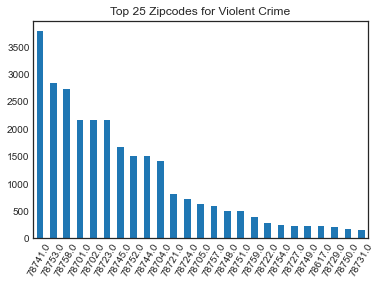

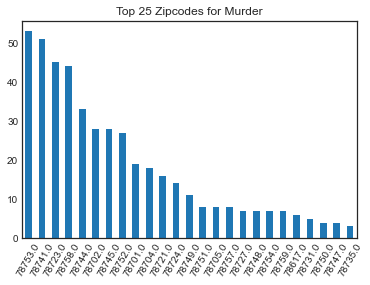

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,14,11,0,1,6
78617.0,120,62,0,6,36
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,66,27,0,2,17
78664.0,3,0,0,0,0


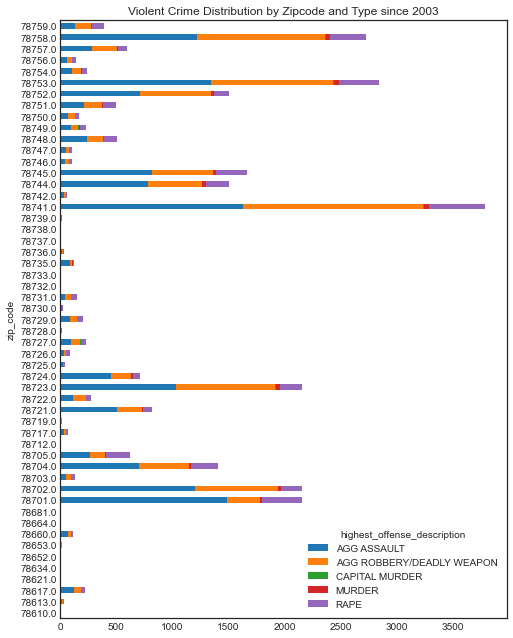

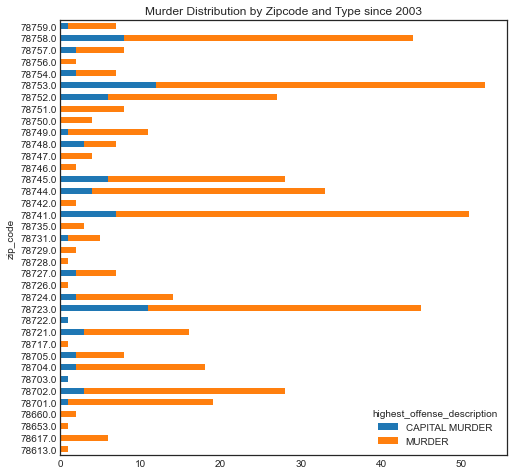

In [13]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == "MURDER"]
df_mur_cap = df[df.highest_offense_description == "CAPITAL MURDER"]
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]
df_rape = df[df.highest_offense_description == "RAPE"]


# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]


# Visualizing overall violent crime trend
# viol_per_year = df_viol["year"].value_counts().sort_index()
# viol_per_year.plot.bar(
#    rot=60, figsize=(10, 5), title="Annual violent crime counts (2003-present)"
# )
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(df_viol.resample("Q").size())
# plt.title("Monthly trend (2003-Present)")
# plt.show()

# As rolling average
df_viol.resample("W").size().rolling(52).sum().plot(
    rot=60, figsize=(8, 4), title="52 week rolling average for violent crime"
)
plt.show()


# Visualizing overall murders
# mur_per_year = df_viol_mur.year.value_counts().sort_index()
# mur_per_year.plot.bar(
#    rot=60, figsize=(10, 5), title="Annual murder counts (2003-present)"
# )
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(df_viol_mur.resample("Q").size())
# plt.title("Monthly trend (2003-Present)")
# plt.show()

# As rolling average
df_viol_mur.resample("W").size().rolling(52).sum().plot(
    rot=60, figsize=(8, 4), title="52 week rolling average for murders"
)
plt.show()

print("==============================================================================")
print("==============================================================================")

# Visualizing yearly violent crime trends for 2017 - 2020
# Overall violent crime by Zipcode
# display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", rot=60
)
plt.show()

# display(df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", rot=60
)
plt.show()


# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
display(viol_freq)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    figsize=(8, 11),
    stacked=True,
)
plt.show()

# Calculating and visualizing frequency rate of murders by zipcode
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
mur_freq.plot.barh(
    figsize=(8, 8),
    title="Murder Distribution by Zipcode and Type since 2003",
    stacked=True,
)
plt.show()

#### Here I broke down the overall  and violent crime dataframes into annual parts, then displaying their rolling averages to compare more closely. 2017-Present.

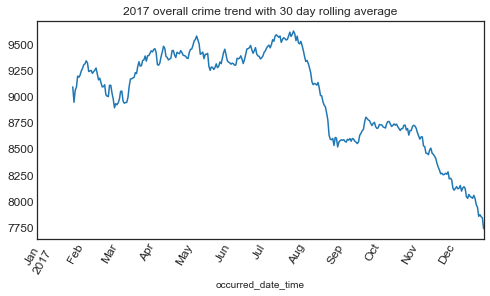

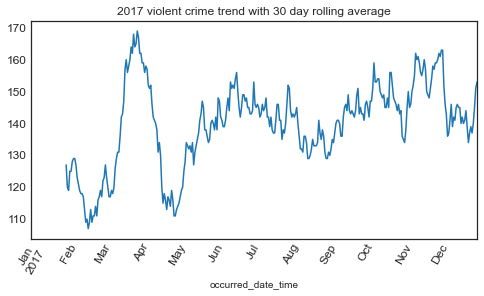

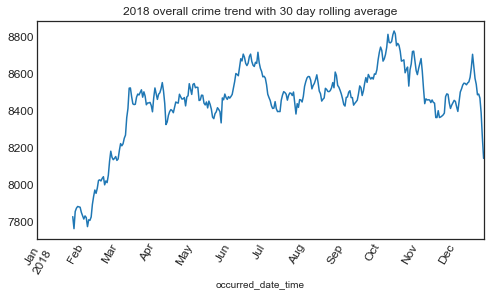

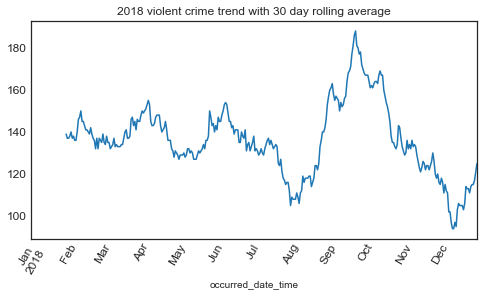

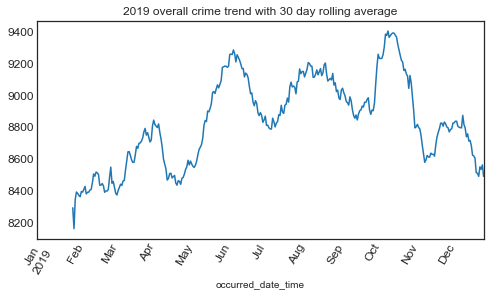

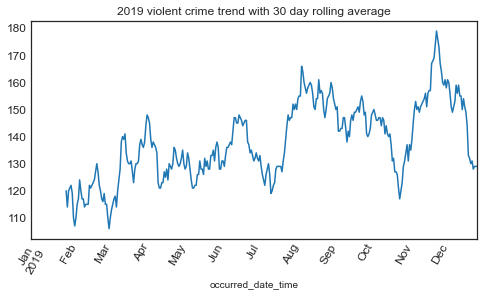

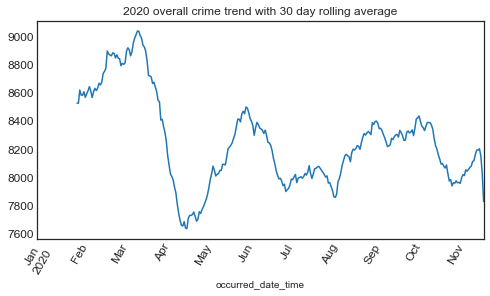

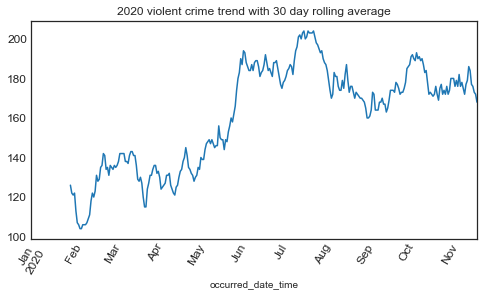

In [14]:
df_17.resample("D").size().rolling(30).sum().plot(fontsize=12, figsize=(8, 4), rot=60)
plt.title("2017 overall crime trend with 30 day rolling average")
plt.show()


df_viol_17.resample("D").size().rolling(30).sum().plot(
    fontsize=12, figsize=(8, 4), rot=60
)
plt.title("2017 violent crime trend with 30 day rolling average")
plt.show()

print("==============================================================================")
print("==============================================================================")


df_18.resample("D").size().rolling(30).sum().plot(fontsize=12, figsize=(8, 4), rot=60)
plt.title("2018 overall crime trend with 30 day rolling average")
plt.show()


df_viol_18.resample("D").size().rolling(30).sum().plot(
    fontsize=12, figsize=(8, 4), rot=60
)
plt.title("2018 violent crime trend with 30 day rolling average")
plt.show()

print("==============================================================================")
print("==============================================================================")


df_19.resample("D").size().rolling(30).sum().plot(fontsize=12, figsize=(8, 4), rot=60)
plt.title("2019 overall crime trend with 30 day rolling average")
plt.show()


df_viol_19.resample("D").size().rolling(30).sum().plot(
    fontsize=12, figsize=(8, 4), rot=60
)
plt.title("2019 violent crime trend with 30 day rolling average")
plt.show()

print("==============================================================================")
print("==============================================================================")


df_20.resample("D").size().rolling(30).sum().plot(fontsize=12, figsize=(8, 4), rot=60)
plt.title("2020 overall crime trend with 30 day rolling average")
plt.show()


df_viol_20.resample("D").size().rolling(30).sum().plot(
    fontsize=12, figsize=(8, 4), rot=60
)
plt.title("2020 violent crime trend with 30 day rolling average")
plt.show()

# ax = df_20.plot(x="year", figsize=(10, 6), label="overall crime")
# df_viol_20.plot(x="year", label="violent crime", ax=ax, rot=60)
# plt.show()

<a id='q8'></a>
### H. Question 8. How is crime distributed across different districts and sectors around Austin? Location types?

#### checking council districts, APD districts, and sectors for overall crime rates 

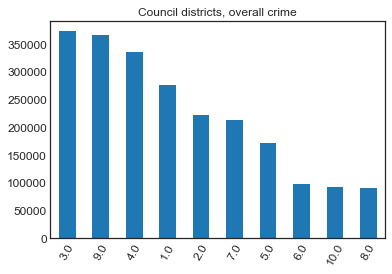

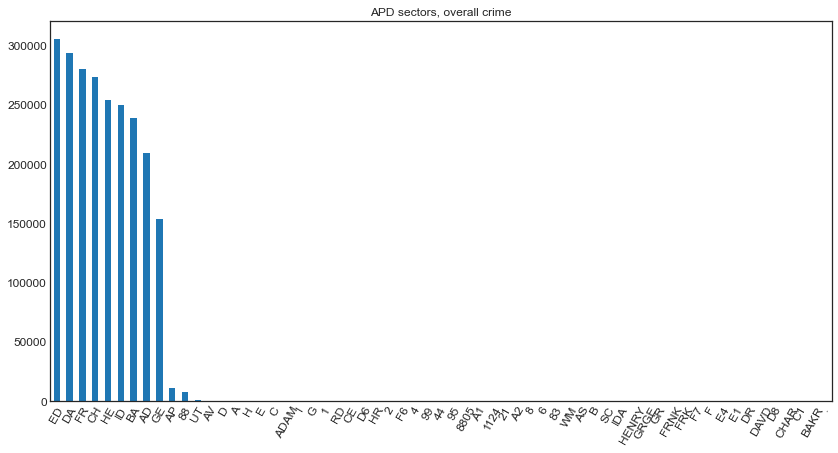

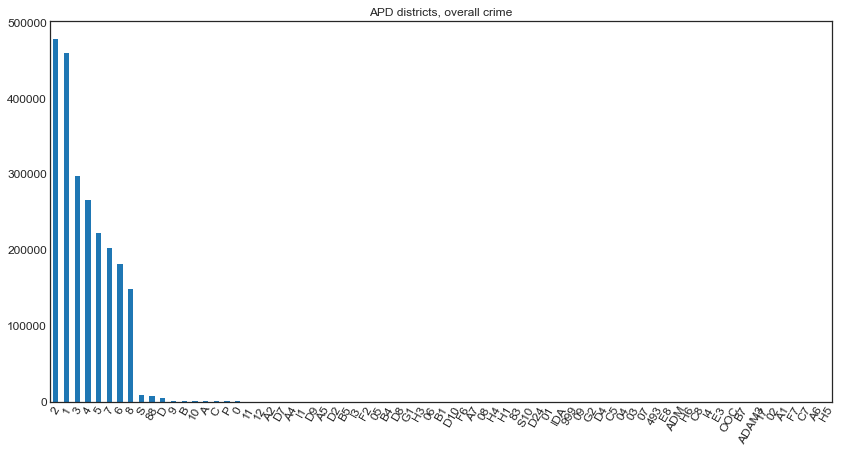

In [15]:
df.council_district.value_counts().plot.bar(
    fontsize=12, title="Council districts, overall crime", rot=60
)
plt.show()

df.apd_sector.value_counts().plot.bar(
    title="APD sectors, overall crime", fontsize=12, figsize=(14, 7), rot=60
)
plt.show()

df.apd_district.value_counts().plot.bar(
    title="APD districts, overall crime", rot=60, fontsize=12, figsize=(14, 7)
)
plt.show()

#### Distribution of violent crime and murders across council districts and APD sectors 

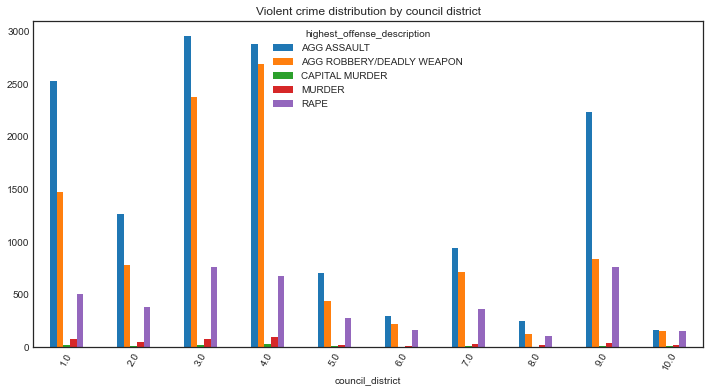

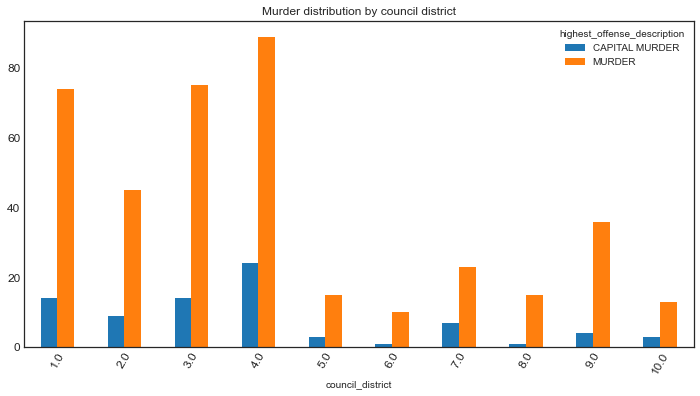

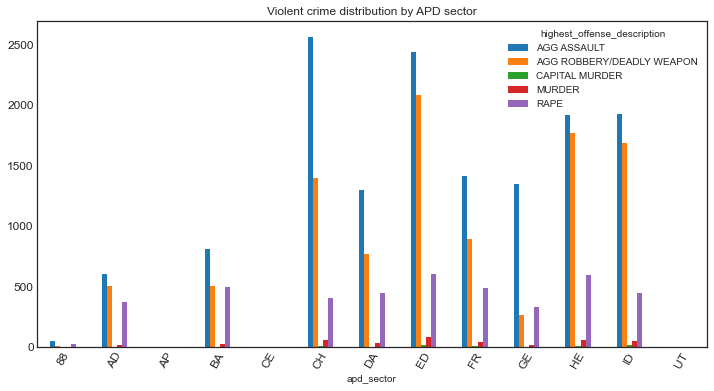

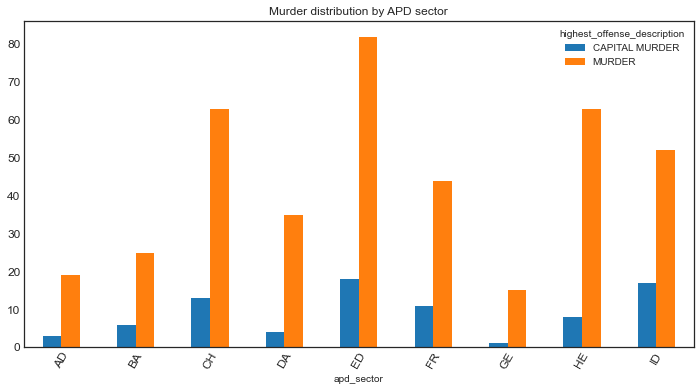

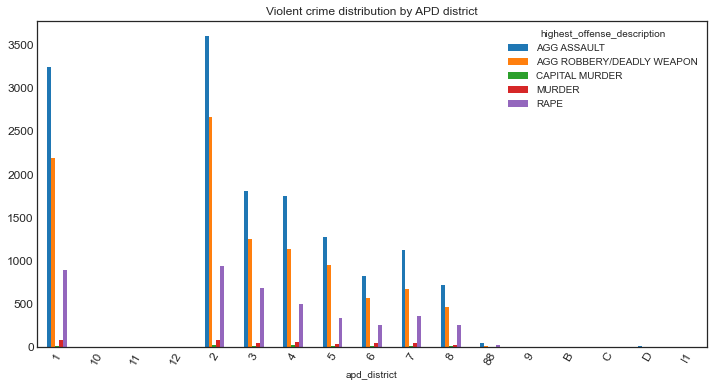

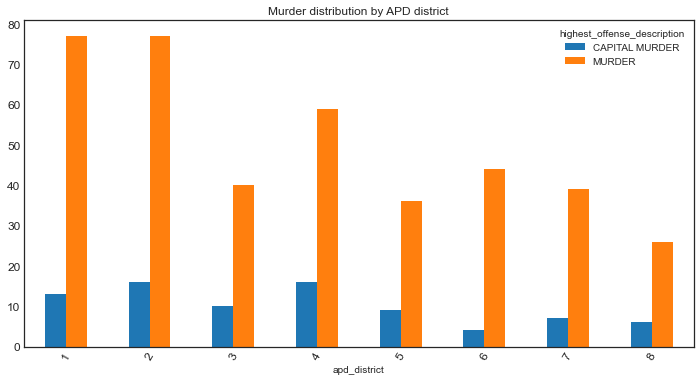

In [16]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    # stacked=True,
    figsize=(12, 6),
    rot=60,
    title="Violent crime distribution by council district",
)
plt.show()


pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(
    figsize=(12, 6),
    rot=60,
    fontsize=12,
    title="Murder distribution by council district",
)
plt.show()


pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    # stacked=True,
    rot=60,
    fontsize=12,
    title="Violent crime distribution by APD sector",
)
plt.show()


pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6),
    rot=60,
    fontsize=12,
    title="Murder distribution by APD sector",
)
plt.show()


pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    # stacked=True,
    rot=60,
    fontsize=12,
    title="Violent crime distribution by APD district",
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6),
    rot=60,
    fontsize=12,
    title="Murder distribution by APD district",
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,0,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,134,0,1,1
BAR / NIGHT CLUB,650,45,2,7,77
CAMP / CAMPGROUND,19,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


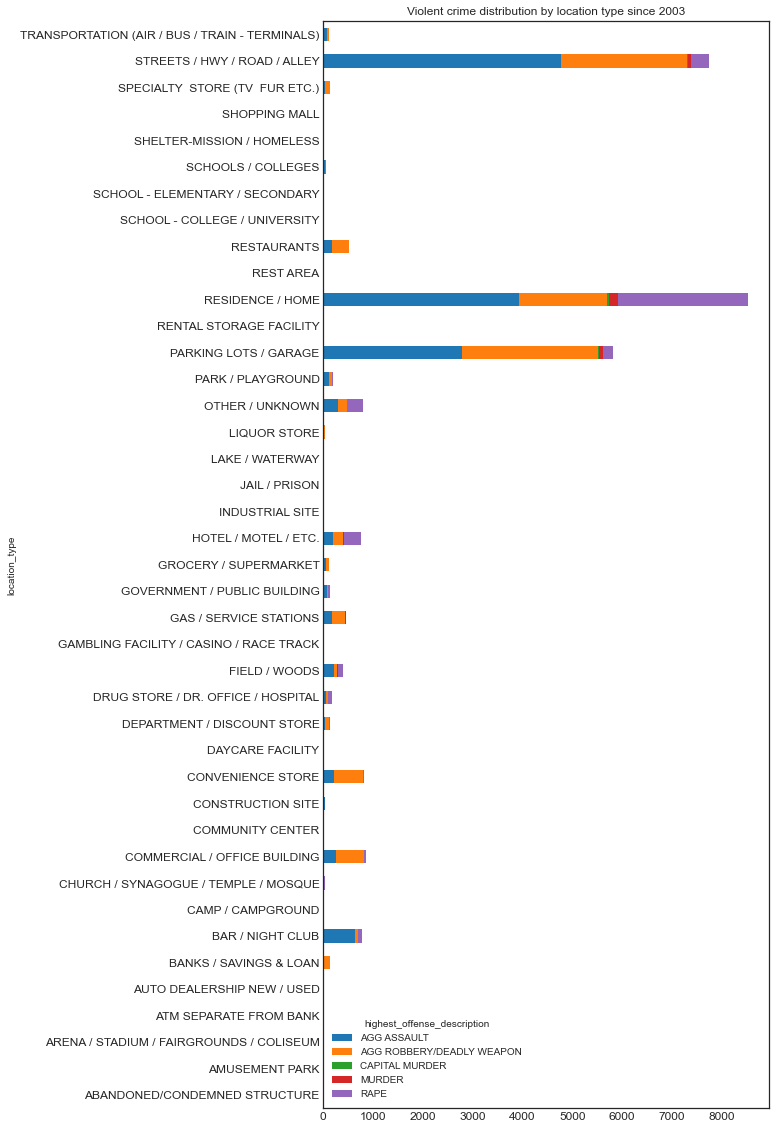

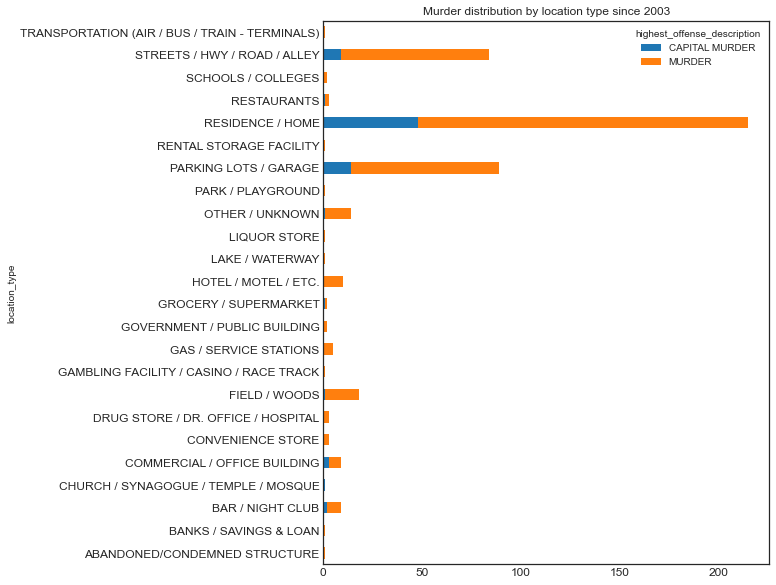

In [17]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)

mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

viol_loc.plot.barh(
    figsize=(8, 20),
    fontsize=12,
    stacked=True,
    title="Violent crime distribution by location type since 2003",
)
plt.show()

mur_loc.plot.barh(
    figsize=(8, 10),
    fontsize=12,
    stacked=True,
    title="Murder distribution by location type since 2003",
)
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [18]:
# Aggravated assault as a heatmap

agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [19]:
# Aggravated robbery a heatmap

agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [20]:
# As a heatmap

mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [21]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                82
9515 N LAMAR BLVD           66
1700 BURTON DR              61
00 BLOCK UNKNOWN            59
6409 SPRINGDALE RD          59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
9200 NORTH PLZ              53
1071 CLAYTON LN             53
1030 NORWOOD PARK BLVD      53
2237 E RIVERSIDE DR         51
1137 GUNTER ST              51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [22]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

8800 N IH 35 SVRD SB         3
4700 E RIVERSIDE DR          3
6409 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
6407 SPRINGDALE RD           3
10503 N LAMAR BLVD           2
601 E 15TH ST                2
815 W SLAUGHTER LN           2
833 FAIRFIELD DR             2
2508 E RIVERSIDE DR          2
6118 FAIRWAY ST              2
9010 GALEWOOD DR             2
1050 SPRINGDALE RD           2
744 W WILLIAM CANNON DR      2
9200 NORTH PLZ               2
2400 WICKERSHAM LN           2
2915 S IH 35 SVRD NB         2
8912 N LAMAR BLVD            2
10610 MORADO CIR             2
2501 ANKEN DR                2
2101 ELMONT DR               2
9601 MIDDLE FISKVILLE RD     2
8225 SAM RAYBURN DR          2
2713 S CONGRESS AVE          2
7000 DECKER LN               2
605 MASTERSON PASS           2
1711 RUTLAND DR              2
6600 ED BLUESTEIN BLVD SB    2
201 W 5TH ST                 2
1137 GUNTER ST               2
9220 N IH 35 SVRD SB         2
Name: address, dtype: int64

## IV. Summary 

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.23 percentage points higher than the number 2 area 78753 which hosts 7.82% of overall crime.

As we can see, violent crime spiked tremendously after 2018, and especially for 2020 so far.

Years 2010 and 2016 had the most number of murders. However, and alarmingly, as of 11/23/2020, we've now had more murders this year than any other since 2003. Presently, the murder count for 2020 is at 39!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

In [27]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")